In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import random
import gc

In [2]:
base_path = '/home/data/m5/'

In [3]:
%%time
calendar = pd.read_csv(f"{base_path}calendar.csv")
df = pd.read_csv(f'{base_path}sales_train_validation.csv')
sell_prices = pd.read_csv(f"{base_path}sell_prices.csv")
sample_sub = pd.read_csv(f"{base_path}sample_submission.csv")

CPU times: user 4.94 s, sys: 574 ms, total: 5.52 s
Wall time: 5.52 s


In [4]:
# Melt the data to get it in long format
df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], 
             var_name="d", 
             value_name="sales")

# Filter for a single time series
# Change these IDs to the IDs of the store and item you're interested in
df = df[(df['store_id'] == 'CA_1') & (df['item_id'] == 'HOBBIES_1_001')]

In [5]:
# Load calendar data

# Merge calendar data with main data
df = df.merge(calendar, how='left', validate='many_to_one')

# Convert date to datetime format and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [6]:
print(df.isnull().sum())

id                 0
item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
d                  0
sales              0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
event_name_1    1759
event_type_1    1759
event_name_2    1909
event_type_2    1909
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64


In [8]:
df = df.fillna(method='ffill')

In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

check_stationarity(df['sales'])

ADF Statistic: -2.117796
p-value: 0.237419


In [14]:
df = df.dropna()

In [15]:
check_stationarity(df['sales'])

ADF Statistic: -17.544948
p-value: 0.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2011-04-24 to 2016-04-24
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1828 non-null   object 
 1   item_id       1828 non-null   object 
 2   dept_id       1828 non-null   object 
 3   cat_id        1828 non-null   object 
 4   store_id      1828 non-null   object 
 5   state_id      1828 non-null   object 
 6   d             1828 non-null   object 
 7   sales         1828 non-null   float64
 8   wm_yr_wk      1828 non-null   int64  
 9   weekday       1828 non-null   object 
 10  wday          1828 non-null   int64  
 11  month         1828 non-null   int64  
 12  year          1828 non-null   int64  
 13  event_name_1  1828 non-null   object 
 14  event_type_1  1828 non-null   object 
 15  event_name_2  1828 non-null   object 
 16  event_type_2  1828 non-null   object 
 17  snap_CA       1828 non-null   int64  
 18  snap_TX   

In [17]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,
2011-04-24,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_86,0.0,11113,Sunday,2,4,2011,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
2011-04-25,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_87,0.0,11113,Monday,3,4,2011,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
2011-04-26,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_88,0.0,11113,Tuesday,4,4,2011,Pesach End,Religious,Easter,Cultural,0,0,0
2011-04-27,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_89,0.0,11113,Wednesday,5,4,2011,Pesach End,Religious,Easter,Cultural,0,0,0
2011-04-28,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_90,0.0,11113,Thursday,6,4,2011,Pesach End,Religious,Easter,Cultural,0,0,0


In [18]:
# Calculate IQR
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['sales'] < Q1 - 1.5 * IQR) | (df['sales'] > Q3 + 1.5 * IQR)]

print(f'Number of outliers: {outliers.shape[0]}')


Number of outliers: 538


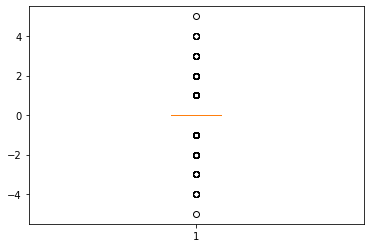

In [19]:
import matplotlib.pyplot as plt

plt.boxplot(df['sales'])
plt.show()


In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


In [21]:
# Split into train and test sets
size = int(len(df) * 0.8)
train, test = df['sales'][0:size], df['sales'][size:len(df)]

# Fit and predict
history = [x for x in train]
predictions = list()

In [23]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))  # You might need to adjust the order parameters based on your data
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

Test RMSE: 1.2200205991342725


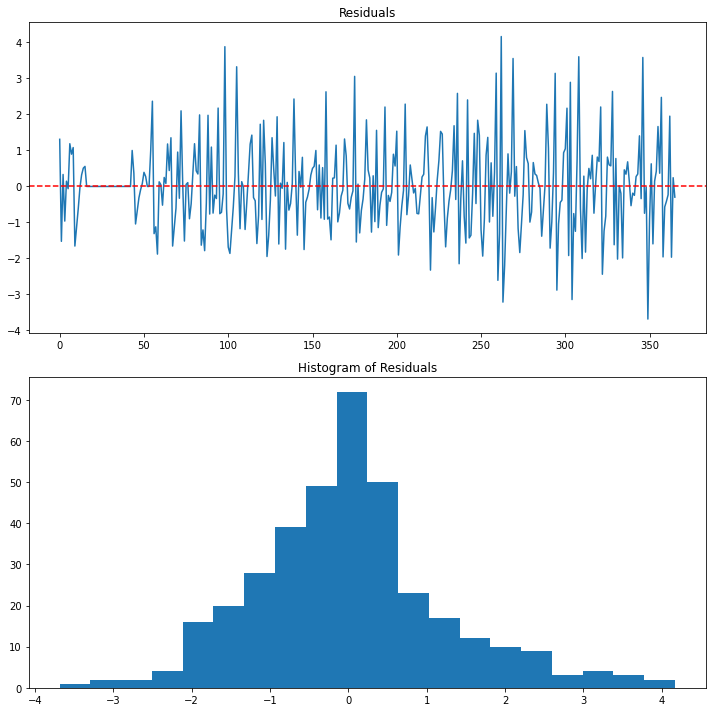

In [24]:
residuals = [test[i]-predictions[i] for i in range(len(test))]

# Create subplot
fig, ax = plt.subplots(2,1, figsize=(10,10))

# Plot residuals
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].axhline(0, color='r', linestyle='--')  # This adds a horizontal line at zero on the residual plot

# Plot histogram of residuals
ax[1].hist(residuals, bins=20)
ax[1].set_title('Histogram of Residuals')

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Compute MAE
mae = mean_absolute_error(test, predictions)
print(f'Test MAE: {mae}')

Test MAE: 0.896492500327735
Test MAPE: inf%


In [26]:
# Compute MAPE
mape = np.mean(np.abs((test - predictions) / test)) * 100
print(f'Test MAPE: {mape}%')

Test MAPE: inf%


In [27]:
mape

inf

In [28]:
test

date
2015-04-25    2.0
2015-04-26   -2.0
2015-04-27    1.0
2015-04-28   -1.0
2015-04-29    0.0
             ... 
2016-04-20    0.0
2016-04-21    2.0
2016-04-22   -3.0
2016-04-23    1.0
2016-04-24    0.0
Name: sales, Length: 366, dtype: float64

In [29]:
epsilon = 1e-10  # Small constant to avoid division by zero
mape = np.mean(np.abs((test - predictions) / (test + epsilon))) * 100
print(f'Test MAPE: {mape}%')

Test MAPE: 188110854261.43945%
